In [112]:
import re
import nltk
import pickle
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
!python -m nltk.downloader stopwords wordnet punkt averaged_perceptron_tagger
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.layers import Attention
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
!pip install rouge
from rouge import Rouge
from sklearn.model_selection import StratifiedKFold

/usr/lib/python3.6/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Hyperparameters

In [0]:
BATCH_SIZE=1
EPOCHS=200
latent_dim=256
embedding_dim=100
test_train_split=0.15
build_number="1"
LEARNING_RATE=0.0001

In [0]:
# create rouge object for evaluation
rouge = Rouge()

## Data Processing

Read In Data

In [115]:
# Only needed if running on Google Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
df = pd.read_csv('./drive/My Drive/repeat.csv')
# df = pd.read_csv('./Reviews.csv')

In [117]:
df.count

<bound method DataFrame.count of       Unnamed: 0  ...                                            summary
0              0  ...  Syrian official Obama climbed top tree doesnt ...
1              1  ...  Syrian official Obama climbed top tree doesnt ...
2              2  ...  Syrian official Obama climbed top tree doesnt ...
3              3  ...  Syrian official Obama climbed top tree doesnt ...
4              4  ...  Syrian official Obama climbed top tree doesnt ...
...          ...  ...                                                ...
3096        3096  ...  Syrian official Obama climbed top tree doesnt ...
3097        3097  ...  Syrian official Obama climbed top tree doesnt ...
3098        3098  ...  Syrian official Obama climbed top tree doesnt ...
3099        3099  ...  Syrian official Obama climbed top tree doesnt ...
3100        3100  ...  Syrian official Obama climbed top tree doesnt ...

[3101 rows x 4 columns]>

In [118]:
df.head()

,Unnamed: 0,file,text,summary
0,0,0001d1afc246a7964130f43ae940af6bc6c57f01.story,Its official US President Barack Obama want la...,Syrian official Obama climbed top tree doesnt ...
1,1,0002095e55fcbd3a2f366d9bf92a95433dc305ef.story,Its official US President Barack Obama want la...,Syrian official Obama climbed top tree doesnt ...
2,2,00027e965c8264c35cc1bc55556db388da82b07f.story,Its official US President Barack Obama want la...,Syrian official Obama climbed top tree doesnt ...
3,3,0002c17436637c4fe1837c935c04de47adb18e9a.story,Its official US President Barack Obama want la...,Syrian official Obama climbed top tree doesnt ...
4,4,0003ad6ef0c37534f80b55b4235108024b407f0b.story,Its official US President Barack Obama want la...,Syrian official Obama climbed top tree doesnt ...


Remove .'s that appear in stuff like U.S.A and U.N - Eventually need to move this to dataprocessing.py

In [0]:
# print(df['summary'][0])
# df['summary'] = df['summary'].apply(lambda x: re.sub(r'\..*$',' ',str(x)))
# print(df['summary'][0])

In [120]:
print(df['summary'][0])
df['summary'] = df['summary'].apply(lambda x: re.sub(r'\.','',str(x)))
print(df['summary'][0])

Syrian official Obama climbed top tree doesnt know get Obama sends letter heads House Senate Obama seek congressional approval military action Syria Aim determine whether CW used says U.N. spokesman
Syrian official Obama climbed top tree doesnt know get Obama sends letter heads House Senate Obama seek congressional approval military action Syria Aim determine whether CW used says UN spokesman


Check for rows with null values in them, and copy these into a new dataframe (df1). Drop any rows in df1 from df to ensure no NaN valued rows are present/

*Note. using simply dropna(how='any') does not seem to drop any of the rows*

In [121]:
print(df.isnull().values.any())
print(df.shape)

df1 = df[df.isna().any(axis=1)]
print(df1.shape)

df.drop(df1.index, axis=0,inplace=True)
print(df.shape)
print(df.isnull().values.any())

False
(3101, 4)
(0, 4)
(3101, 4)
False


Cut down text to 20 words, and summaries to 10

In [122]:
print(df['text'][0])
df['text'] = df['text'].apply(lambda x: nltk.word_tokenize(x)).apply(lambda x: " ".join(x[:20]))
print(df['text'][0])

Its official US President Barack Obama want lawmaker weigh whether use military force Syria Obama sent letter head House Senate Saturday night hour announce believe military action Syrian target right step take allege use chemical weapon The propose legislation Obama asks Congress approve use military force deter disrupt prevent degrade potential future us chemical weapon weapon mass destruction Its step set turn international crisis fierce domestic political battle There key question loom debate What UN weapon inspector find Syria What happens Congress vote And Syrian government react In televise address White House Rose Garden earlier Saturday president say would take case Congress want While I believe I authority carry military action without specific congressional authorization I know country strong take course action even effective say We debate issue big business usual Obama say top congressional leader agree schedule debate body return Washington September 9 The Senate Foreign R

In [123]:
print(df['summary'][0])
df['summary'] = df['summary'].apply(lambda x: nltk.word_tokenize(x)).apply(lambda x: " ".join(x[:10]))
print(df['summary'][0])

Syrian official Obama climbed top tree doesnt know get Obama sends letter heads House Senate Obama seek congressional approval military action Syria Aim determine whether CW used says UN spokesman
Syrian official Obama climbed top tree doesnt know get Obama


Word Count Distribution

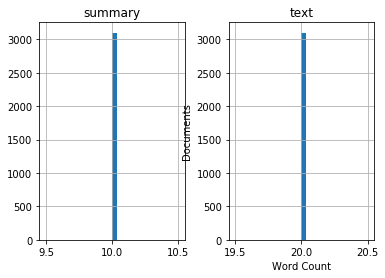

In [124]:
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in df['text']:
      text_word_count.append(len(i.split(' ')))

for i in df['summary']:
      summary_word_count.append(len(i.split(' ')))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.ylabel('Documents')
plt.xlabel('Word Count')
# plt.savefig('word_count_distro' + str(build_number) + '.png')
plt.show()

In [125]:
word_dict = {}
text = df['text'].apply(lambda x: nltk.word_tokenize(x))

for index, row in text.iteritems():
  for word in row:
    if word not in word_dict.keys():
      word_dict[word] = 1
    else:
      word_dict[word] += 1

print(len(word_dict))
sorted_dict = sorted(word_dict.items(), key=lambda x: x[1], reverse=True)
print(sorted_dict)
x, y = zip(*sorted_dict)

19
[('Obama', 6202), ('Its', 3101), ('official', 3101), ('US', 3101), ('President', 3101), ('Barack', 3101), ('want', 3101), ('lawmaker', 3101), ('weigh', 3101), ('whether', 3101), ('use', 3101), ('military', 3101), ('force', 3101), ('Syria', 3101), ('sent', 3101), ('letter', 3101), ('head', 3101), ('House', 3101), ('Senate', 3101)]


In [126]:
# accept_words = list(x[3:])
accept_words = list(x)
accept_words = [x.lower() for x in accept_words]
print(accept_words)
print(df['text'][2])
# print(df['text'][451])
df['text'] = df['text'].apply(lambda x: nltk.word_tokenize(x)).apply(lambda x: " ".join([word for word in x if word.lower() in accept_words]))
print(df['text'][2])
# print(df['text'][451])

['obama', 'its', 'official', 'us', 'president', 'barack', 'want', 'lawmaker', 'weigh', 'whether', 'use', 'military', 'force', 'syria', 'sent', 'letter', 'head', 'house', 'senate']
Its official US President Barack Obama want lawmaker weigh whether use military force Syria Obama sent letter head House Senate
Its official US President Barack Obama want lawmaker weigh whether use military force Syria Obama sent letter head House Senate


In [127]:
word_dict = {}
text = df['summary'].apply(lambda x: nltk.word_tokenize(x))

for index, row in text.iteritems():
  for word in row:
    if word not in word_dict.keys():
      word_dict[word] = 1
    else:
      word_dict[word] += 1

print(len(word_dict))
sorted_dict = sorted(word_dict.items(), key=lambda x: x[1], reverse=True)
print(sorted_dict)
x, y = zip(*sorted_dict)

9
[('Obama', 6202), ('Syrian', 3101), ('official', 3101), ('climbed', 3101), ('top', 3101), ('tree', 3101), ('doesnt', 3101), ('know', 3101), ('get', 3101)]


In [128]:
# accept_words = list(x[4:])
accept_words = list(x)
accept_words = [x.lower() for x in accept_words]
print(accept_words)
print(df['summary'][2])
# print(df['summary'][451])
df['summary'] = df['summary'].apply(lambda x: nltk.word_tokenize(x)).apply(lambda x: " ".join([word for word in x if word.lower() in accept_words]))
print(df['summary'][2])
# print(df['summary'][451])

['obama', 'syrian', 'official', 'climbed', 'top', 'tree', 'doesnt', 'know', 'get']
Syrian official Obama climbed top tree doesnt know get Obama
Syrian official Obama climbed top tree doesnt know get Obama


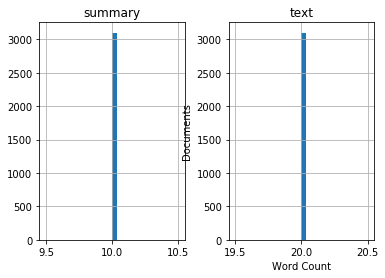

In [129]:
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in df['text']:
      text_word_count.append(len(i.split(' ')))

for i in df['summary']:
      summary_word_count.append(len(i.split(' ')))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.ylabel('Documents')
plt.xlabel('Word Count')
# plt.savefig('word_count_distro' + str(build_number) + '.png')
plt.show()

Max Text Lengths

In [130]:
max_text_len = max([len(txt.split(' ')) for txt in df['text']])
max_summary_len = max([len(txt.split(' ')) for txt in df['summary']])
print(max_text_len)
print(max_summary_len)

20
10


### Training-Validation Split

X - Articles text </br>
Y - Summaries

In [0]:
# convert to numpy array
X = np.array(df['text'])
Y = np.array(df['summary'])

In [132]:
x_tr,x_val,y_tr,y_val=train_test_split(X,Y,test_size=test_train_split,random_state=0,shuffle=True)
print(x_tr.shape)
print(x_val.shape)
print(y_tr.shape)
print(y_val.shape)

(2635,)
(466,)
(2635,)
(466,)


## GloVe

In [0]:
embedding_index = {}
with open('./drive/My Drive/glove/glove.6B.' + str(embedding_dim) + 'd.txt') as f:
  for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coefs


In [134]:
print(len(embedding_index))

400000


In [135]:
print(embedding_index.get("us"))

[ 3.3090e-01  1.0111e+00  1.5401e+00 -3.7205e-03 -1.6854e-01 -3.6448e-01
 -4.9264e-01 -2.7382e-01  4.2796e-02 -1.0149e-01  8.2923e-01 -2.1641e-01
  1.8006e-01  2.2698e-01  1.4333e-02  2.6679e-01 -1.7742e-01 -3.5467e-01
 -6.1956e-01  8.1431e-01  1.2080e+00 -6.4785e-02  1.1816e-01  1.9243e-01
 -2.6561e-02  2.8291e-01  1.8635e-01 -6.3154e-01  1.0080e+00 -3.3754e-01
  3.1217e-02  5.5929e-01 -3.4031e-01 -3.8397e-02 -8.6859e-02  7.0105e-01
 -4.7500e-01  1.2132e-01  3.8364e-01  3.1194e-01 -7.7032e-01 -8.4787e-01
  1.2489e-04  2.3546e-01  3.7578e-01 -1.7466e-01 -6.8517e-01 -3.4409e-01
 -6.0872e-01 -1.6763e+00  1.5370e-01 -6.7015e-02  7.4586e-01  1.1758e+00
 -5.2170e-01 -2.4951e+00  3.1104e-01 -4.2603e-01  2.1117e+00  1.8723e-02
  4.0115e-01  4.1757e-01 -2.1425e-01 -1.9927e-01 -5.3570e-01  9.3413e-02
 -4.2322e-02  1.0767e+00  1.0693e-01  3.8199e-01  3.4468e-01 -4.3743e-01
 -7.7398e-01 -4.2631e-01  2.3625e-01 -7.5068e-02  5.1797e-01  4.3557e-01
 -1.4849e+00  1.4530e-01  1.0455e+00 -1.5742e-01 -9

### Word Embeddings - Tokenization

X Tokenizer

In [136]:
word_dict = {}
text = df['text']

for row in text: 
  for word in row.split(" "):
    if word not in word_dict:
      word_dict[word] = 1
    else:
      word_dict[word] += 1

print(len(word_dict))

19


In [137]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=len(word_dict), split=" ") 
x_tokenizer.fit_on_texts(list(X))

x_embedding_matrix = np.zeros(((x_tokenizer.num_words)+1, embedding_dim),dtype='float32')
print(x_embedding_matrix.shape)
for word,i in x_tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        # Words not found in glove will be zeros
        x_embedding_matrix[i] = embedding_vector

(20, 100)


In [138]:
# # #prepare a tokenizer for reviews on training data
# x_tokenizer = Tokenizer(num_words=len(word_dict), split=" ") 
# x_tokenizer.fit_on_texts(list(X))

# #convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=x_voc, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=x_voc, padding='post')

print(x_voc)

20


In [139]:
print(x_tokenizer.num_words)
print(x_voc)

19
20


Y Tokenizer

In [140]:
y_word_dict = {}
summ = df['summary']

for row in summ: 
  for word in row.split(" "):
    if word not in y_word_dict:
      y_word_dict[word] = 1
    else:
      y_word_dict[word] += 1

print(len(y_word_dict))

9


In [141]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=len(y_word_dict), split=" ") 
y_tokenizer.fit_on_texts(list(Y))

y_embedding_matrix = np.zeros((x_tokenizer.num_words +1, embedding_dim),dtype='float32')
print(y_embedding_matrix.shape)
print(len( y_tokenizer.word_index))
for word,i in y_tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
    # Words not found in glove will be zeros
        y_embedding_matrix[i] = embedding_vector

(20, 100)
9


In [142]:
#prepare a tokenizer for reviews on training data
# y_tokenizer = Tokenizer(num_words=len(y_word_dict), split=" ") 
# y_tokenizer.fit_on_texts(list(Y))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#size of vocabulary
y_voc  =   y_tokenizer.num_words + 1

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=x_voc, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=x_voc, padding='post')

print(y_voc)

10


## Learning Model

#### Encoder Model

In [0]:
# bidirectional encoder
encoder_inputs = Input(shape=(x_voc,))
#embedding layer
# changed trainable to false
# enc_emb_layer =  Embedding(x_voc,embedding_dim,trainable=True)
enc_emb_layer = Embedding(x_voc, embedding_dim, weights=[x_embedding_matrix], 
                          input_length=x_voc, trainable=False)
enc_emb = enc_emb_layer(encoder_inputs)

#encoder lstm 
encoder_lstm = Bidirectional(LSTM(latent_dim,return_sequences=True,return_state=True))
encoder_outputs, fw_state_h, fw_state_c, bw_state_h, bw_state_c = encoder_lstm(enc_emb)

state_h = Concatenate()([fw_state_h, bw_state_h])
state_c = Concatenate()([fw_state_c, bw_state_c])
encoder_states = [state_h, state_c]

#### Decoder Model

In [0]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(x_voc,))

#embedding layer
#changed trainable to false
# dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=False)
dec_emb_layer = Embedding(x_voc, embedding_dim,
                          weights=[y_embedding_matrix], input_length=x_voc, 
                          trainable=False)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(
    dec_emb, initial_state=encoder_states)
                                                          
#dense layer
decoder_dense = Dense(y_voc, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

#### Combined LSTM Model

In [145]:
# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 20, 100)      2000        input_6[0][0]                    
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) [(None, 20, 512), (N 731136      embedding_3[0][0]                
____________________________________________________________________________________________

In [0]:
optimizer = RMSprop(lr=LEARNING_RATE, rho=0.9)

In [0]:
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')

- Early Stopping Callback to ensure we stop when Validation Loss is lowest - minimises risk of overfitting
- Model Checkpoint saves the model after each epoch so that we can load the model with the best weights later on. Alternatively, it allows us to continue training the model at a later data



In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3, restore_best_weights=False)
filepath = "./drive/My Drive/project-model/saved-model-{epoch:02d}.hdf5"
mc = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

#### Use this method to train a new model. To continue training a previously trained model see below

In [0]:
# history = model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:], batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[es], validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

In [150]:
print(x_tr.shape)
print(y_tr.shape)
print(y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1).shape)
print(y_val.reshape(y_val.shape[0],y_val.shape[1], 1).shape)
y_tr_3d = y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)
y_val_3d = y_val.reshape(y_val.shape[0],y_val.shape[1], 1)

(2635, 20)
(2635, 20)
(2635, 20, 1)
(466, 20, 1)


In [151]:
history = model.fit([x_tr,y_tr], y_tr_3d, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[es],
                    validation_data=([x_val,y_val], y_val_3d))

Train on 2635 samples, validate on 466 samples
Epoch 1/200
2635/2635 [==============================] - 191s 73ms/step - loss: 0.0185 - val_loss: 1.0431e-06
Epoch 2/200
2635/2635 [==============================] - 189s 72ms/step - loss: 1.0431e-06 - val_loss: 1.0431e-06
Epoch 3/200
2635/2635 [==============================] - 188s 71ms/step - loss: 1.0431e-06 - val_loss: 1.0431e-06
Epoch 4/200
2635/2635 [==============================] - 188s 71ms/step - loss: 1.0431e-06 - val_loss: 1.0431e-06
Epoch 00004: early stopping


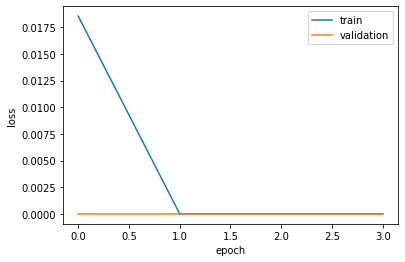

In [162]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
# plt.savefig('loss' + str(build_number) + '.png')
plt.show()

In [163]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
print(reverse_source_word_index)
print(reverse_target_word_index)

{1: 'obama', 2: 'its', 3: 'official', 4: 'us', 5: 'president', 6: 'barack', 7: 'want', 8: 'lawmaker', 9: 'weigh', 10: 'whether', 11: 'use', 12: 'military', 13: 'force', 14: 'syria', 15: 'sent', 16: 'letter', 17: 'head', 18: 'house', 19: 'senate'}
{1: 'obama', 2: 'syrian', 3: 'official', 4: 'climbed', 5: 'top', 6: 'tree', 7: 'doesnt', 8: 'know', 9: 'get'}


In [0]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

In [165]:
encoder_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 20, 100)      2000        input_6[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) [(None, 20, 512), (N 731136      embedding_3[0][0]                
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 512)          0           bidirectional_2[0][1]            
                                                                 bidirectional_2[0][3]      

In [0]:
# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim*2,))
decoder_state_input_c = Input(shape=(latent_dim*2,))
decoder_hidden_state_input = Input(shape=(x_voc,latent_dim*2))
decoder_state_inputs = [decoder_state_input_h, decoder_state_input_c]

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_state_inputs)
decoder_states = [state_h2, state_c2]
# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c], [decoder_outputs2] + decoder_states)
# decoder_model = Model([decoder_inputs] + decoder_state_inputs, [decoder_outputs2] + decoder_states)


In [167]:
decoder_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 20, 100)      2000        input_7[0][0]                    
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 512)          0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 512)          0                                            
____________________________________________________________________________________________

### Methods for Reversing Word Embeddings

In [0]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

### Summarisation Method 

In [0]:
def decode_sequence(input_seq): 
    # Encode the input as state vectors.
    print(input_seq)
    print(input_seq.shape)
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    print(e_out)
    # target = [0,0,0....n] where n = y_voc
    target_seq = np.zeros((1, x_voc))
    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
      # Model([decoder_inputs] + decoder_state_inputs, [decoder_outputs2] + decoder_states)
      # print(target_seq)
      output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c]) 
      print(output_tokens.shape)
      print(output_tokens)
      print("output tokens")
      print(output_tokens[0,-1,:])
      print("output tokens")
      print(output_tokens[0,-1,:][1:])
      sampled_token_index = np.argmax(output_tokens[0, -1, :][1:])
      print(sampled_token_index)
      if (sampled_token_index != 0 ):
        sampled_token = reverse_target_word_index[sampled_token_index]
        # print(sampled_token)
        decoded_sentence += ' '+sampled_token
      else :
        print("sadface")
        stop_condition = True
      if (len(decoded_sentence.split()) >= (max_summary_len-1)):
              stop_condition = True
       # Update the target sequence (of length 1).
      # target_seq = np.zeros((1,1))
      # target_seq = np.zeros((1, x_voc))
      target_seq[0, sampled_token_index] = 1

      # Update internal states
      e_h, e_c = h, c
      
    return decoded_sentence

## Test Model Output

In [0]:
def getRouge(gt, pred):
  return rouge.get_scores(pred, gt)

In [174]:
for i in range(0,1):
    print("Article:",seq2text(x_tr[i]))
    original = seq2summary(y_tr[i])
    print("Original summary:",original)
    x_tr_i_reshaped = x_tr[i].reshape(1,x_voc)
    summary = decode_sequence(x_tr_i_reshaped)
    print("Generated summary:",summary)
    print("\n")

    if summary != "":    
      print("ROUGE score: ")
      score = getRouge(str(summary), str(original))
      print(score)
      print(score[0].get('rouge-1').get('f'))
      print(score[0].get('rouge-1').get('p'))
      print(score[0].get('rouge-1').get('r'))

Article: its official us president barack obama want lawmaker weigh whether use military force syria obama sent letter head house 
Original summary: syrian official obama climbed top tree doesnt know obama 
[[ 2  3  4  5  6  1  7  8  9 10 11 12 13 14  1 15 16 17 18  0]]
(1, 20)
[[[ 4.1656800e-02  1.0902033e-02 -7.2615750e-02 ...  7.7172351e-01
   -6.7435265e-01  1.5189697e-01]
  [ 1.3945213e-01 -4.5042783e-02  2.5325678e-02 ...  7.7451581e-01
   -6.7368346e-01  5.3700652e-02]
  [ 2.9121146e-01 -1.1370844e-01  6.8969657e-03 ...  8.2819051e-01
   -5.6722373e-01  8.5950434e-02]
  ...
  [ 9.3707448e-01 -7.0112735e-01 -1.4408523e-01 ...  6.7345262e-02
    4.8367284e-02 -2.2426569e-01]
  [ 9.0694654e-01 -7.1426046e-01 -1.9990830e-01 ...  5.1457468e-02
    2.3265777e-02 -1.7249219e-01]
  [ 8.6897141e-01 -6.1195588e-01 -2.3943530e-01 ...  8.9212495e-04
   -1.0112840e-03  6.5416803e-05]]]
(1, 20, 10)
[[[6.26644917e-11 1.31391458e-08 9.99999046e-01 1.01045975e-06
   1.29495803e-09 1.31506903e-10